In [1]:
## Notebook for extracting pupil data etc

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
# general imports
import sys
import pickle
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd
import copy
from tqdm import tqdm

import popoff
import pop_off_functions as pof
import pop_off_plotting as pop

from Session import Session, SessionLite, build_flu_array_single
from linear_model import PoolAcrossSessions, LinearModel, MultiSessionModel


/home/tplas/repos/popping-off/popoff/popoff/loadpaths.py
/home/tplas/repos/Vape


In [2]:
## Load sessions
pas = PoolAcrossSessions(remove_targets=False, subsample_sessions=False,
                         remove_toosoon=True, pre_start=-0.51)

for ss in pas.sessions.values():
    _ = pop.normalise_raster_data(session=ss, sort_neurons=False, filter_150_stim=False)
    

long post time
long post time
long post time
long post time
long post time
Mouse RL070, run 29  registered no-lick hit. changed to too soon
long post time
long post time
Mouse RL117, run 29  registered no-lick hit. changed to too soon
Mouse RL117, run 29  registered no-lick hit. changed to too soon
long post time
long post time
long post time
Mouse RL116, run 32  registered no-lick hit. changed to too soon
Mouse RL116, run 32  registered no-lick hit. changed to too soon
Mouse RL116, run 32  registered no-lick hit. changed to too soon
long post time
ALERT SESSIONS NOT SUBSAMPLED
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time


In [3]:
## Load pop var
reg_list = ['s1', 's2']
cov_dicts = {x: {} for x in reg_list}
super_covar_df_dict = {}
for i_reg, reg in enumerate(reg_list):
    print(reg)
    for i_lm, linear_model in tqdm(enumerate(pas.linear_models)):
        name = pas.sessions[i_lm].mouse + '_' + str(pas.sessions[i_lm].run_number)
        # if name in ['RL117_29', 'RL117_30']:
        cov_dicts[reg][i_lm] = pof.get_covariates(linear_model, reg, hitmiss_only=False,
                                                filter_150=False)

    super_covar_df_dict[reg] = pof.create_df_from_cov_dicts(cov_dicts=cov_dicts[reg], 
                                                  zscore_list=['variance_cell_rates', 'mean_pre'])

0it [00:00, ?it/s]

s1


11it [03:32, 19.33s/it]
0it [00:00, ?it/s]

s2


11it [02:55, 15.97s/it]


In [6]:
pas.sessions

{0: instance Mouse J064, run 10 of Session class,
 1: instance Mouse J064, run 11 of Session class,
 2: instance Mouse J064, run 14 of Session class,
 3: instance Mouse RL070, run 28 of Session class,
 4: instance Mouse RL070, run 29 of Session class,
 5: instance Mouse RL117, run 26 of Session class,
 6: instance Mouse RL117, run 29 of Session class,
 7: instance Mouse RL117, run 30 of Session class,
 8: instance Mouse RL123, run 22 of Session class,
 9: instance Mouse RL116, run 32 of Session class,
 10: instance Mouse RL116, run 33 of Session class}

In [4]:
# ## put your path to your vape repo here 
# path_to_vape = os.path.expanduser('~/Documents/code/Vape/')
# popoff_path = '/home/jrowland/Documents/code/pop-off/scripts/'

# # Bit hacky but oh well
# sys.path.append(path_to_vape)
# sys.path.append(os.path.join(path_to_vape, 'utils'))
# sys.path.append(popoff_path)

# from utils.utils_funcs import d_prime

In [8]:
# df_pupil_mice = pd.DataFrame({'mouse': ['RL117', 'RL117'], 'run_number': [29, 30],
#                               'filename_prefix': ['2021-03-09_RL117', '2021-03-10_RL117']})
df_pupil_mice = pd.DataFrame({'mouse': ['RL117', 'RL117', 'RL123'], 'run_number': [29, 30, 22],
                              'filename_prefix': ['2021-03-09_RL117', '2021-03-10_RL117', None]})
df_pupil_mice['signature'] = df_pupil_mice['mouse'] + '_' + df_pupil_mice['run_number'].astype(str)
df_pupil_mice

,mouse,run_number,filename_prefix,signature
0,RL117,29,2021-03-09_RL117,RL117_29
1,RL117,30,2021-03-10_RL117,RL117_30
2,RL123,22,None,RL123_22


In [15]:

def consecutive(data, stepsize=1):
    '''https://stackoverflow.com/questions/7352684/how-to-find-the-groups-of-consecutive-elements-in-a-numpy-array'''
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

def handle_outliers(data_arr=None, bool_good_dp=None, bool_bad_dp=None):
    '''bool_good_dp: inds of ones to keep, bad vice versa'''
    data_arr = copy.deepcopy(data_arr)
    if bool_bad_dp is None and bool_good_dp is not None:
        tmp_bool_arr = np.ones(len(data_arr), dtype='bool')
        tmp_bool_arr[bool_good_dp] = False 

        nan_inds = np.where(np.isnan(data_arr))[0]
        tmp_bool_arr[nan_inds] = True
        tmp_bool_arr = np.where(tmp_bool_arr)[0]
        list_of_outlier_intervals = consecutive(tmp_bool_arr)
    elif bool_good_dp is None and bool_bad_dp is not None:
        print('WARNING: no nan correction yet!!')
        list_of_outlier_intervals = consecutive(bool_bad_dp)
    for interval in list_of_outlier_intervals:
        start_dp = interval[0] - 1
        end_dp = interval[-1] + 1
        n_dps = len(interval)

        if end_dp > len(data_arr) - 1:
            print('last ind is outlier')
            # diff_start = np.diff(data_arr[start_dp - 1:start_dp + 1])
            # linear_interpolation = np.linspace(data_arr[start_dp], data_arr[stdict_pupil_data[signature]['area_array']art_dp] + diff_start * n_dps, n_dps + 1)
            # data_arr[start_dp:end_dp] = np.squeeze(linear_interpolation)
            data_arr[start_dp:end_dp] = data_arr[start_dp]

        elif start_dp == -1:
            print('first ind is outlier')
            data_arr[:end_dp] = data_arr[end_dp]

        else:
            linear_interpolation = np.linspace(data_arr[start_dp], data_arr[end_dp], n_dps + 2)
            assert linear_interpolation[0] == data_arr[start_dp], f'{start_dp, end_dp, data_arr[start_dp], data_arr[end_dp], linear_interpolation[0]}'
            assert linear_interpolation[-1] == data_arr[end_dp]
            data_arr[start_dp:end_dp + 1] = linear_interpolation
        
    return data_arr
    
def load_pupil_data(df_pupil_mice, dir='/home/tplas/data/mice'):
    dict_pupil_data = {signature: {} for signature in df_pupil_mice['signature']}

    for i_sess, signature in enumerate(dict_pupil_data.keys()):
        print(signature)
        if signature != 'RL123_22':
            basic_filename = os.path.join(dir, 'pupil_data_2022-11-11/', df_pupil_mice[df_pupil_mice['signature'] == signature]['filename_prefix'].iloc[0])
            dict_pupil_data[signature]['area_array'] = np.load(basic_filename + '_AreaArray.npy')
            dict_pupil_data[signature]['binary_score'] = np.load(basic_filename + '_BinaryScore.npy')
            dict_pupil_data[signature]['r2_distance'] = np.load(basic_filename + '_r2Distance.npy')
            dict_pupil_data[signature]['binary_score'] = np.concatenate((dict_pupil_data[signature]['binary_score'], np.where(np.isnan(dict_pupil_data[signature]['area_array']))[0]))
            dict_pupil_data[signature]['binary_score'] = np.sort(np.unique(dict_pupil_data[signature]['binary_score'] ))
            dict_pupil_data[signature]['area_array_corrected'] = handle_outliers(data_arr=dict_pupil_data[signature]['area_array'],
                                                                                bool_good_dp=dict_pupil_data[signature]['binary_score'])
        
        if signature == 'RL117_29':
            new_fn = os.path.join(dir, 'pupil_data_2022-11-28/2021-03-09_RL117_pupil_2021-03-09-145620_croppedMinimallyDaskAnnotated0-12_FixedCenter65.85_allFrames_resArray.npy')
        elif signature == 'RL117_30':
            new_fn = os.path.join(dir, 'pupil_data_2022-11-28/2021-03-10_RL117_pupil_2021-03-10-164145_croppedMinimallyDaskAnnotated0-10_FixedCenter55.75_allFrames_resArray.npy')
        elif signature == 'RL123_22':
            new_fn = os.path.join(dir, 'pupil_data_2022-11-28/2021-03-10_RL123_pupil_2021-03-10-185442_croppedMinimallyDaskAnnotated0-10_FixedCenter_allFrames_resArray.npy')

        res_array = np.load(new_fn, 'r')
        a_array = res_array[:,1]
        filtered_a_array = scipy.ndimage.median_filter(a_array, size=6)
        dict_pupil_data[signature]['filtered_a_array'] = filtered_a_array
        if 'area_array_corrected' in dict_pupil_data[signature].keys():
            assert dict_pupil_data[signature]['filtered_a_array'].shape == dict_pupil_data[signature]['area_array_corrected'].shape

    return dict_pupil_data



dict_pupil_data = load_pupil_data(df_pupil_mice=df_pupil_mice)




RL117_29
first ind is outlier
RL117_30
RL123_22


In [14]:
dict_pupil_data['RL117_29']['filtered_a_array'].shape == 

(144512,)

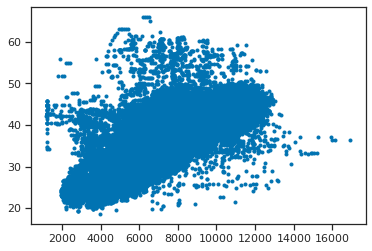

In [25]:

# plt.plot(dict_pupil_data['RL117_29']['area_array_corrected'], 
#          dict_pupil_data['RL117_29']['area_array'], '.')

plt.plot(dict_pupil_data['RL117_29']['area_array_corrected'] ,
         dict_pupil_data['RL117_29']['filtered_a_array'], '.')



In [27]:
## Load run 
def load_run(mouse, run_number, base_path):
    pkl_path = os.path.join(base_path, mouse, f'run{run_number}.pkl')
    print(pkl_path)
    with open(pkl_path, 'rb') as f:
        run = pickle.load(f)
    
    return run

def get_dict_runs(df_pupil_mice):

    dict_runs = {} 
    for i_sess in range(len(df_pupil_mice)):
        print(df_pupil_mice['signature'].iloc[i_sess])
        dict_runs[df_pupil_mice['signature'].iloc[i_sess]] = load_run(mouse=df_pupil_mice['mouse'].iloc[i_sess],
                                                                      run_number=df_pupil_mice['run_number'].iloc[i_sess],
                                                                      base_path='/home/tplas/data/mice/runs/')
    return dict_runs

dict_runs = get_dict_runs(df_pupil_mice=df_pupil_mice)

RL117_29
/home/tplas/data/mice/runs/RL117/run29.pkl
RL117_30
/home/tplas/data/mice/runs/RL117/run30.pkl
RL123_22
/home/tplas/data/mice/runs/RL123/run22.pkl


In [28]:
dict_runs['RL117_29'].flu.shape

(507, 130411)

In [29]:
def filter_frames_first_pass(run, pupil):
    idx_imaged = np.isin(run.frame_clock, run.paqio_frames)
    assert sum(idx_imaged) == run.flu.shape[1]
    assert len(idx_imaged) == len(pupil)
    pupil = pupil[idx_imaged]
    return pupil

def find_session_for_pupil(sess_dict, signature='J064_29'):
    mouse = signature.split('_')[0]
    run_number = int(signature.split('_')[1])

    for i_s, sess in sess_dict.items():
        if mouse == sess.mouse and run_number == sess.run_number:
            return sess

    print('NO session found!')


for signature in dict_pupil_data.keys():
    for name_p in ['area_array', 'r2_distance', 'area_array_corrected', 'filtered_a_array']:
        if name_p in dict_pupil_data[signature].keys():
            dict_pupil_data[signature][name_p] = filter_frames_first_pass(run=dict_runs[signature], 
                                                                      pupil=dict_pupil_data[signature][name_p])

In [31]:
## I am James Rowland and this is my invention:

for signature in df_pupil_mice['signature']:
    corresponding_sess = find_session_for_pupil(sess_dict=pas.sessions, signature=signature)
    
    dict_runs[signature].pupil = np.expand_dims(dict_pupil_data[signature]['filtered_a_array'], 0)  # add to run so we can use build_flu_array_single 
    dict_pupil_data[signature]['pupil_size'] = np.squeeze(build_flu_array_single(run=dict_runs[signature], use_pupil=True, 
                                                                        pre_frames=60, post_frames=120))
                                                                    #   pre_frames=corresponding_sess.pre_frames, 
                                                                    #   post_frames=corresponding_sess.post_frames))  # use session pre_frames & post_frames here

    dict_pupil_data[signature]['pupil_size'] = dict_pupil_data[signature]['pupil_size'][corresponding_sess.nonnan_trials, :]
    print(f'Loaded pupil with shape (trials x time points) {dict_pupil_data[signature]["pupil_size"].shape}')
    assert np.isnan(dict_pupil_data[signature]['pupil_size']).sum() == 0


Loaded pupil with shape (trials x time points) (260, 180)
Loaded pupil with shape (trials x time points) (192, 180)
Loaded pupil with shape (trials x time points) (177, 180)


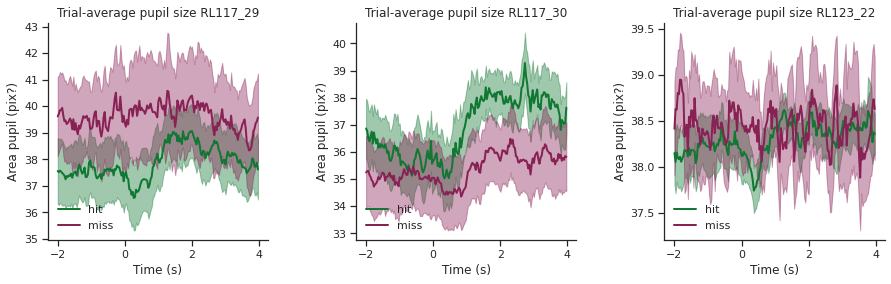

In [84]:
fig, ax = plt.subplots(1, len(dict_pupil_data), figsize=(15, 4), gridspec_kw={'wspace': 0.4})
colors = {'hit': '#117733', 'miss': '#882255'}
for iplot, signature in enumerate(['RL117_29', 'RL117_30', 'RL123_22']):
    curr_ax = ax[iplot]
    pupil_arr = dict_pupil_data[signature]['pupil_size']
    session = find_session_for_pupil(sess_dict=pas.sessions, signature=signature)
    preframes = 60
    time_arr = np.linspace(-2, 4 - 1/30, pupil_arr.shape[1])
    assert len(time_arr) == pupil_arr.shape[1]

    # Baseline the pupil
    baseline = np.mean(pupil_arr[:, :preframes], 1)
    # baseline = np.mean(pupil_arr[:, preframes + 5:preframes + 12], 1)
    # pupil_arr = np.subtract(pupil_arr.T, baseline).T

    for tt in ['hit', 'miss']:
        curr_sel = pupil_arr[session.outcome==tt, :]
        curr_ax.plot(time_arr, curr_sel.mean(0), linewidth=2, color=colors[tt], label=tt)
        ci_95 = curr_sel.std(0) / np.sqrt(curr_sel.shape[0]) * 1.96
        curr_ax.fill_between(x=time_arr, y1=curr_sel.mean(0) - ci_95, 
                             y2=curr_sel.mean(0) + ci_95, color=colors[tt], alpha=0.4)
    
    curr_ax.set_title(f'Trial-average pupil size {signature}')
    curr_ax.set_xlabel('Time (s)')
    curr_ax.set_ylabel('Area pupil (pix?)')
    curr_ax.legend(loc='lower left', frameon=False)
    pop.despine(curr_ax)

In [37]:
pas.sessions

{0: instance Mouse J064, run 10 of Session class,
 1: instance Mouse J064, run 11 of Session class,
 2: instance Mouse J064, run 14 of Session class,
 3: instance Mouse RL070, run 28 of Session class,
 4: instance Mouse RL070, run 29 of Session class,
 5: instance Mouse RL117, run 26 of Session class,
 6: instance Mouse RL117, run 29 of Session class,
 7: instance Mouse RL117, run 30 of Session class,
 8: instance Mouse RL123, run 22 of Session class,
 9: instance Mouse RL116, run 32 of Session class,
 10: instance Mouse RL116, run 33 of Session class}

RL117_29 Mouse RL117, run 29
RL117_30 Mouse RL117, run 30
RL123_22 Mouse RL123, run 22


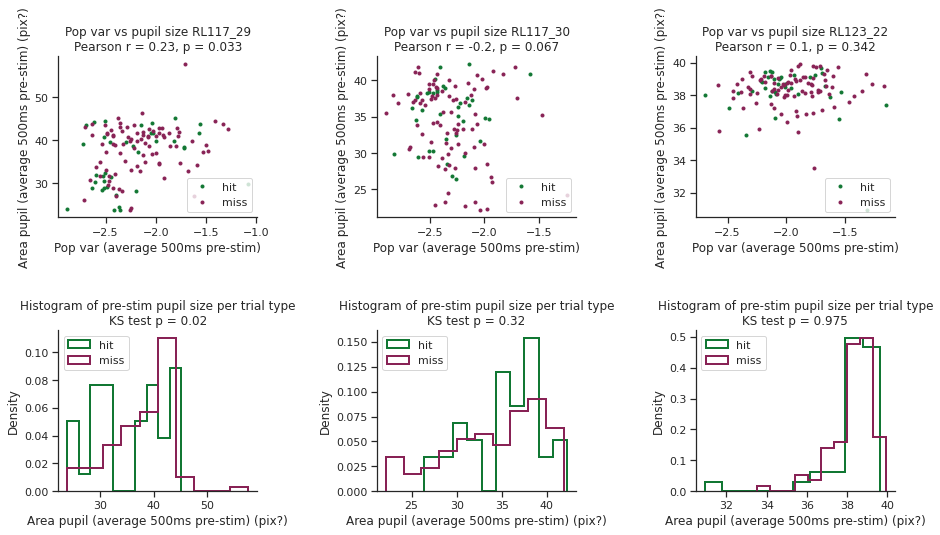

In [79]:
fig, ax = plt.subplots(2, len(dict_pupil_data), figsize=(15, 8), gridspec_kw={'wspace': 0.6, 'hspace': 0.7})
colors = {'hit': '#117733', 'miss': '#882255'}
for iplot, signature in enumerate(['RL117_29', 'RL117_30', 'RL123_22']):
    
    if signature == 'RL117_29':
        i_s = 6
    elif signature == 'RL117_30':
        i_s = 7    
    elif signature == 'RL123_22':
        i_s = 8
    print(signature, pas.sessions[i_s])
    pupil_arr = dict_pupil_data[signature]['pupil_size']
    session = find_session_for_pupil(sess_dict=pas.sessions, signature=signature)
    
    time_slice = slice(45, 60)
    pupil_arr = pupil_arr[:, time_slice] 
    pop_var_arr = cov_dicts['s1'][i_s]['variance_cell_rates']
    # pop_var_arr = cov_dicts['s1'][i_s]['n_cells_stimmed']
    # tmp = cov_dicts['s1'][i_s]['reward']
    # pop_var_arr = np.convolve(tmp, np.ones(10) / 10, mode='same')
    
    
    # preframes = 60
    # time_arr = np.linspace(-2, 4 - 1/30, pupil_arr.shape[1])
    # assert len(time_arr) == pupil_arr.shape[1]

    # # Baseline the pupil
    # baseline = np.mean(pupil_arr[:, :preframes], 1)
    # pupil_arr = np.subtract(pupil_arr.T, baseline).T

    curr_ax = ax[0, iplot]
    select_trials = {}
    for tt in ['hit', 'miss']:
        # select_trials[tt] = session.outcome == tt
        # select_trials[tt] = np.logical_and(session.outcome == tt, session.photostim < 2)
        
        if tt == 'hit':
            tmp = cov_dicts['s1'][0]['reward']
            select_trials[tt] = np.where(np.concatenate((np.array([0]), np.diff(tmp))) == 1)[0]
        elif tt == 'miss':
            tmp = cov_dicts['s1'][0]['reward']
            select_trials[tt] = np.where(np.concatenate((np.array([0]), np.diff(tmp))) == 0)[0]
            # select_trials[tt] = np.where(tmp == 0)[0]


    for tt in ['hit', 'miss']:
        curr_pupil = pupil_arr[select_trials[tt], :]
        curr_popvar = pop_var_arr[select_trials[tt]]

        curr_ax.plot(curr_popvar, curr_pupil.mean(1), '.', color=colors[tt], label=tt)
    corr = scipy.stats.pearsonr(curr_popvar, curr_pupil.mean(1))

    curr_ax.set_title(f'Pop var vs pupil size {signature}\nPearson r = {np.round(corr[0], 2)}, p = {np.round(corr[1], 3)}')
    curr_ax.set_xlabel('Pop var (average 500ms pre-stim)')
    curr_ax.set_ylabel('Area pupil (average 500ms pre-stim) (pix?)')
    curr_ax.legend(loc='lower right', frameon=True)
    pop.despine(curr_ax)

    curr_ax = ax[1, iplot]

    curr_pupil = {}
    for tt in ['hit', 'miss']:
        curr_pupil[tt] = pupil_arr[select_trials[tt], :]

        curr_ax.hist(curr_pupil[tt].mean(1), histtype='step', density=True, 
                     color=colors[tt], label=tt, linewidth=2)

    ksresults = scipy.stats.kstest(curr_pupil['hit'].mean(1), curr_pupil['miss'].mean(1), alternative='two-sided')
    # print(ksresults)
    curr_ax.set_title(f'Histogram of pre-stim pupil size per trial type\nKS test p = {np.round(ksresults[1], 3)}')
    curr_ax.set_xlabel('Area pupil (average 500ms pre-stim) (pix?)')
    curr_ax.set_ylabel('Density')
    curr_ax.legend(loc='upper left', frameon=True)
    pop.despine(curr_ax)


162
[0 0 1 0 0 0 1 0 0 1 1 0 1 1 0 0 0 0 1 1 0 1 0 1 0 0 0 0 1 0 1 1 0 1 1 0 0
 0 1 0 1 0 0 1 0 1 1 1 1 1 0 1 1 1 0 1 1 0 1 0 0 1 0 1 1 1 1 1 1 0 0 0 0 1
 1 1 1 0 0 1 0 0 1 0 1 0 0 1 1 0 1 1 0 1 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 1
 0 0 0 0 1 1 0 0 0 0 0 1 0 0 1 1 1 1 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 0  0  1 -1  0  0  1 -1  0  1  0 -1  1  0 -1  0  0  0  1  0 -1  1 -1  1
 -1  0  0  0  1 -1  1  0 -1  1  0 -1  0  0  1 -1  1 -1  0  1 -1  1  0  0
  0  0 -1  1  0  0 -1  1  0 -1  1 -1  0  1 -1  1  0  0  0  0  0 -1  0  0
  0  1  0  0  0 -1  0  1 -1  0  1 -1  1 -1  0  1  0 -1  1  0 -1  1 -1  0
  1 -1  0  0  0  0  0  1 -1  1  0 -1  0  0  1 -1  0  0  0  1  0 -1  0  0
  0  0  1 -1  0  1  0  0  0 -1  0  1 -1  0  0  1  0  0 -1  0  0  1 -1  0
  0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


## Done:
- Show dynamics of pupil size on hit vs miss trials (validation that it worked) => **Seems to be an effect**
- Show histogram of pre-stim pupil size hit vs miss => **No effect**
- Scatter plot pupil size vs pop var (just pre-stim) => **No effect**
- Smooth across trial performance (eg smooth across 10 trials and correlate performance vs pupil size)  **No effect**
- Band by n_stim? 150 vs 5-50; **No effect** split by n_stim!  **To do**
- Optionally, as control, compare pupil size pre-stim vs n_stim **No effect**
- Select only hit trials that follow a miss **Not really an effect, just RL117_29 very slightly**



## Analysis to do:
- Scatter plot pupil size vs pop var (full dynamics)
- band by pop var?
- Correlation to difference in behaviour between sessions to understand variability between sessions? [sort of like smoothing trial performance]